In [1]:
# 1. Setup và Config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

import xgboost as xgb

RANDOM_STATE = 42
N_JOBS = -1

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def eval_on_logscale(pred_log, y_log_true):
    rmse_log = np.sqrt(mean_squared_error(y_log_true, pred_log))
    pred = np.expm1(pred_log); true = np.expm1(y_log_true)
    return {
        "rmse_log": rmse_log,
        "rmse": rmse(true, pred),
        "r2_log": r2_score(y_log_true, pred_log)
    }


In [2]:
# 2. Load dữ liệu
df = pd.read_csv("VN_BĐS_data/property_final_clean.csv", low_memory=False)
print(df.shape)
display(df.head(5))

(66926, 10)


,cleaned_area,cleaned_road,bed,bath,floor,is_land,tag,Loại địa ốc,Pháp lý,cleaned_price
0,77.0,12.5,3.0,2.0,3.0,0,da_nang,bán nhà riêng,NaN,15000.0
1,205.0,12.5,5.0,3.0,2.0,0,da_nang,bán nhà riêng,Sổ hồng,11500.0
2,96.0,12.5,3.0,2.0,3.0,0,da_nang,bán nhà riêng,NaN,4750.0
3,92.0,12.5,3.0,2.0,3.0,0,da_nang,bán căn hộ chung cư,NaN,1400.0
4,105.0,12.5,3.0,2.0,3.0,0,da_nang,bán căn hộ chung cư,NaN,5145.0


In [3]:
# 3. Tổng quan và missing
display(df.dtypes.value_counts())
na = df.isnull().sum().sort_values(ascending=False)
display(na[na>0].head(20))

float64    6
object     3
int64      1
Name: count, dtype: int64

Pháp lý        25519
Loại địa ốc      103
dtype: int64

In [4]:
# 1. Với Loại địa ốc: Chỉ thiếu ít (110 dòng) -> Xóa bỏ để sạch dữ liệu
print(f"Số dòng trước khi xóa Loại địa ốc thiếu: {df.shape[0]}")
df = df.dropna(subset=['Loại địa ốc'])
print(f"Số dòng sau khi xóa: {df.shape[0]}")

# 2. Với Pháp lý: Thiếu nhiều -> Điền là 'Chưa xác định'
# (Coi sự thiếu hụt này là một loại trạng thái pháp lý riêng)
df['Pháp lý'] = df['Pháp lý'].fillna('Chưa xác định')

# Kiểm tra lại lần cuối xem còn sót không
print("\nKiểm tra lại dữ liệu thiếu:")
print(df[['Loại địa ốc', 'Pháp lý']].isnull().sum())

Số dòng trước khi xóa Loại địa ốc thiếu: 66926
Số dòng sau khi xóa: 66823

Kiểm tra lại dữ liệu thiếu:
Loại địa ốc    0
Pháp lý        0
dtype: int64


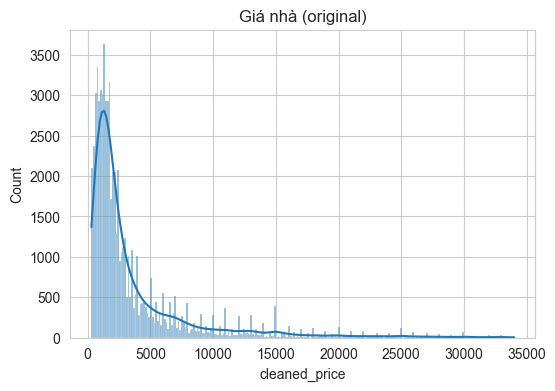

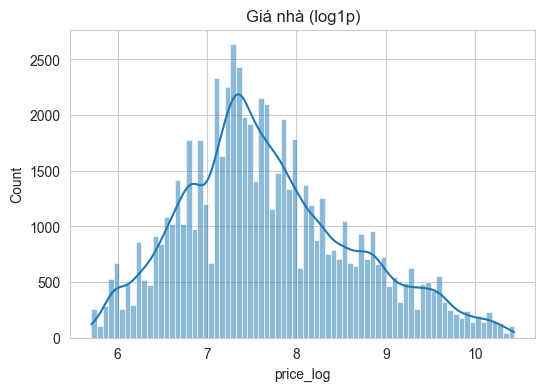

In [5]:
# 4. Target distribution + log1p
fig = plt.figure(figsize=(6,4))
sns.histplot(df["cleaned_price"], kde=True)
plt.title("Giá nhà (original)")
plt.show()

df["price_log"] = np.log1p(df["cleaned_price"])
fig = plt.figure(figsize=(6,4))
sns.histplot(df["price_log"], kde=True)
plt.title("Giá nhà (log1p)")
plt.show()

Top 10 numeric tương quan mạnh nhất:


cleaned_price    1.000000
price_log        0.849168
bed              0.401003
bath             0.384654
cleaned_area     0.306122
cleaned_road     0.080589
floor            0.078586
is_land         -0.325262
Name: cleaned_price, dtype: float64


Top 10 categorical tương quan mạnh nhất (sau target encoding):


Loại địa ốc    0.465078
tag            0.376374
Pháp lý        0.075638
Name: cleaned_price, dtype: float64

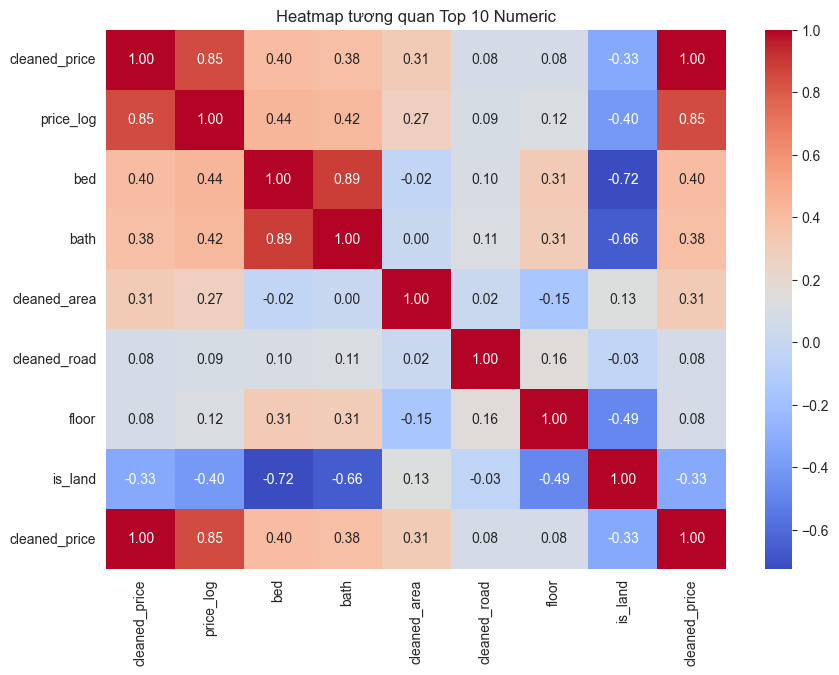

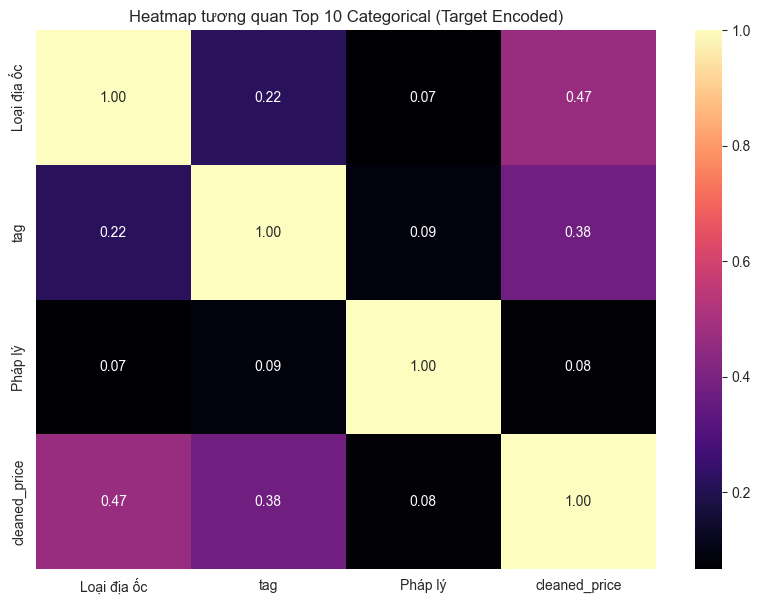

In [6]:
#5

from category_encoders.target_encoder import TargetEncoder

# Lấy danh sách cột numeric & categorical
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

# 2. Target Encoding cho categorical
encoder = TargetEncoder(cols=cat_cols)
df_cat_enc = encoder.fit_transform(df[cat_cols], df["cleaned_price"])

# 3. Gộp numeric + categorical đã mã hóa
corr_data = pd.concat([df[num_cols], df_cat_enc], axis=1)

# 4. Tính ma trận tương quan với Giá nhà
corr_all = corr_data.corr()["cleaned_price"].sort_values(ascending=False)

# Lấy top 10 numeric + top 10 categorical mạnh nhất
top_num_corr = corr_all[corr_all.index.isin(num_cols)].head(10)
top_cat_corr = corr_all[corr_all.index.isin(cat_cols)].head(10)

print("Top 10 numeric tương quan mạnh nhất:")
display(top_num_corr)

print("\nTop 10 categorical tương quan mạnh nhất (sau target encoding):")
display(top_cat_corr)

# 5.1 Heatmap cho Top 10 Numeric
num_features = list(top_num_corr.index) + ["cleaned_price"]
corr_num_matrix = corr_data[num_features].corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr_num_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap tương quan Top 10 Numeric")
plt.show()

# 5.2 Heatmap cho Top 10 Categorical (Encoded)
cat_features = list(top_cat_corr.index) + ["cleaned_price"]
corr_cat_matrix = corr_data[cat_features].corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr_cat_matrix, annot=True, cmap="magma", fmt=".2f")
plt.title("Heatmap tương quan Top 10 Categorical (Target Encoded)")
plt.show()

Top các feature numeric tương quan mạnh nhất với Giá nhà:


Index(['price_log', 'bed', 'bath', 'cleaned_area', 'cleaned_road', 'floor',
       'is_land'],
      dtype='object')

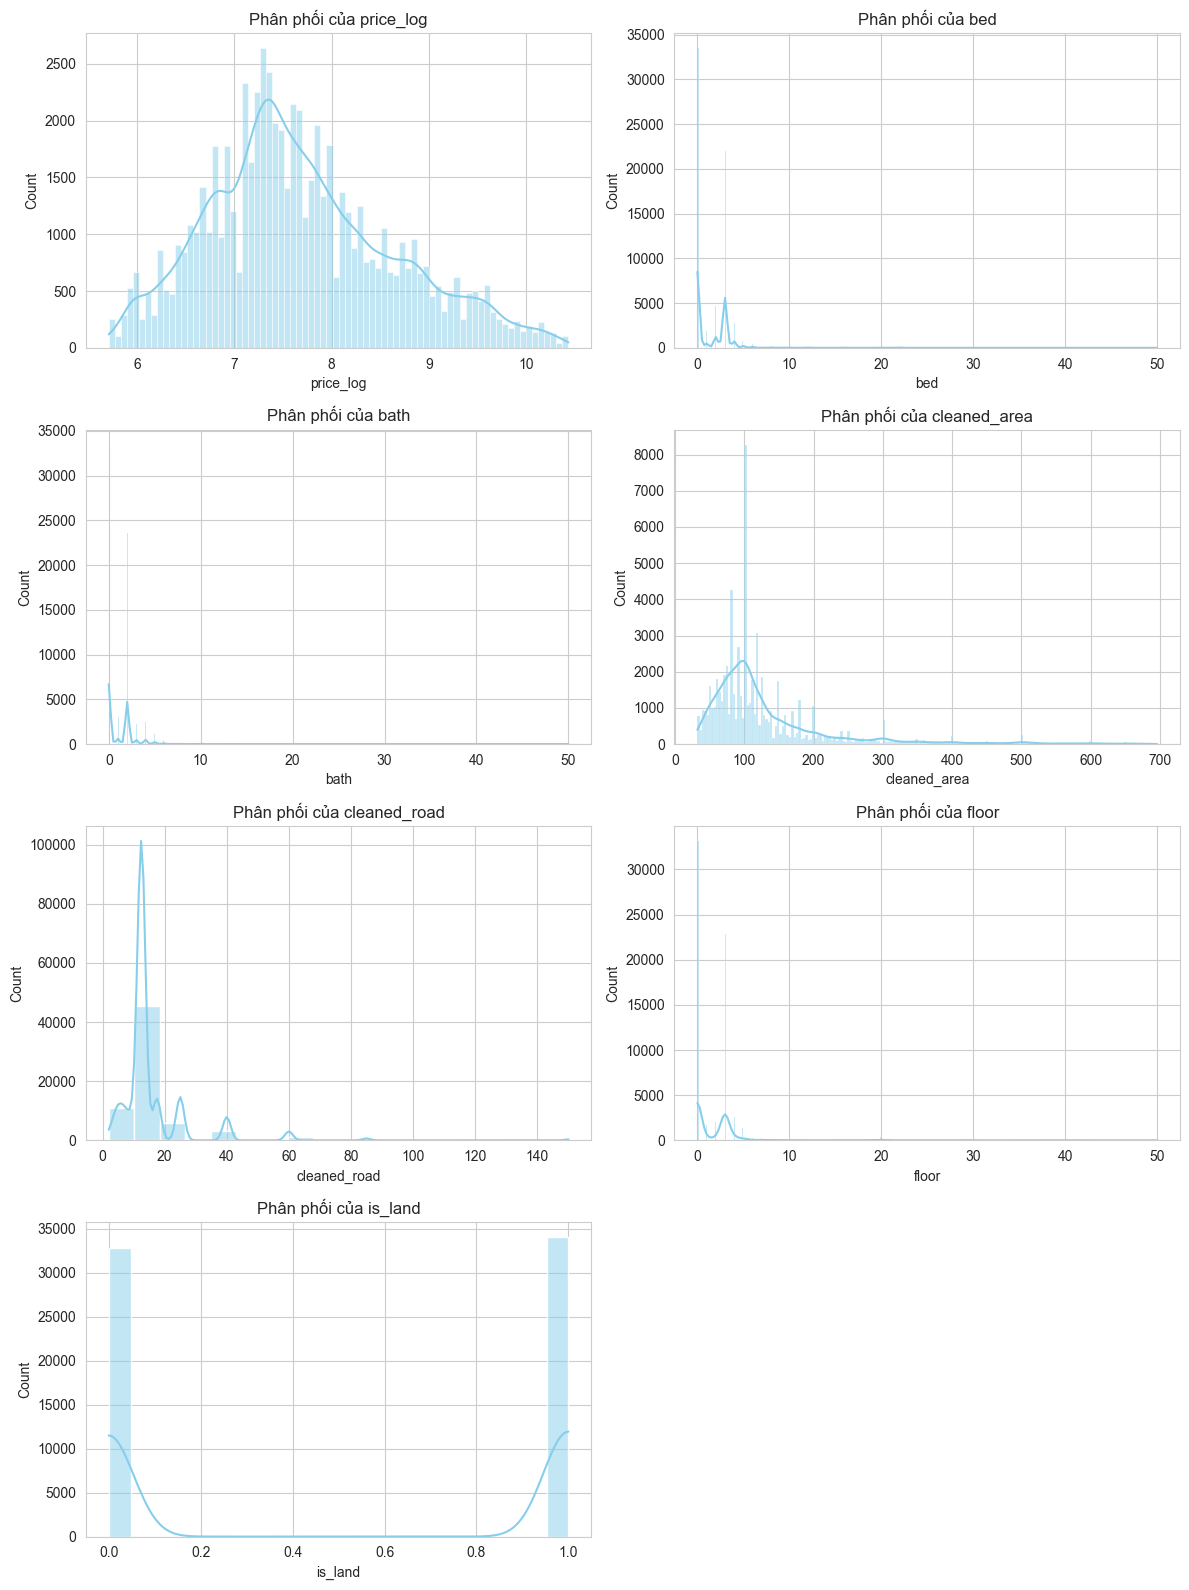

Top 3 biến phân loại có ít giá trị duy nhất nhất:


['Pháp lý', 'Loại địa ốc', 'tag']

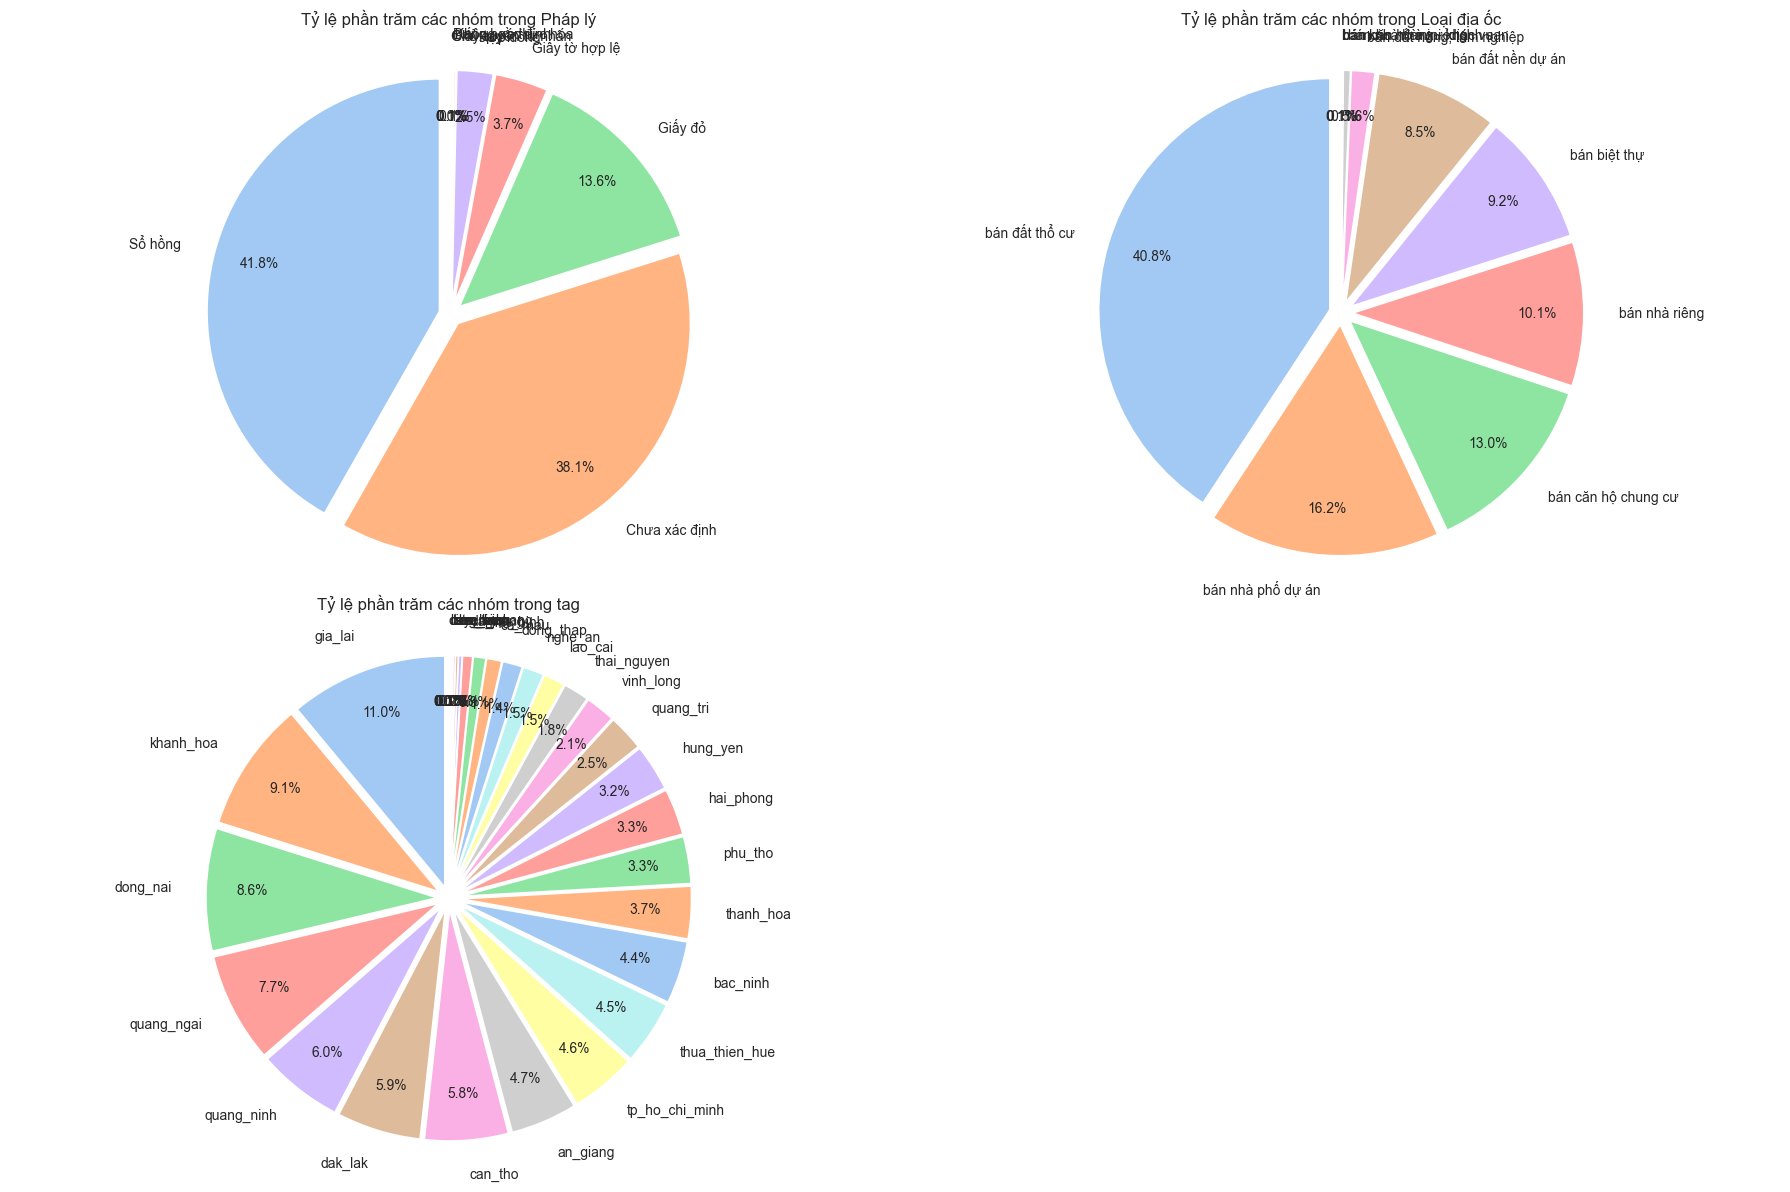

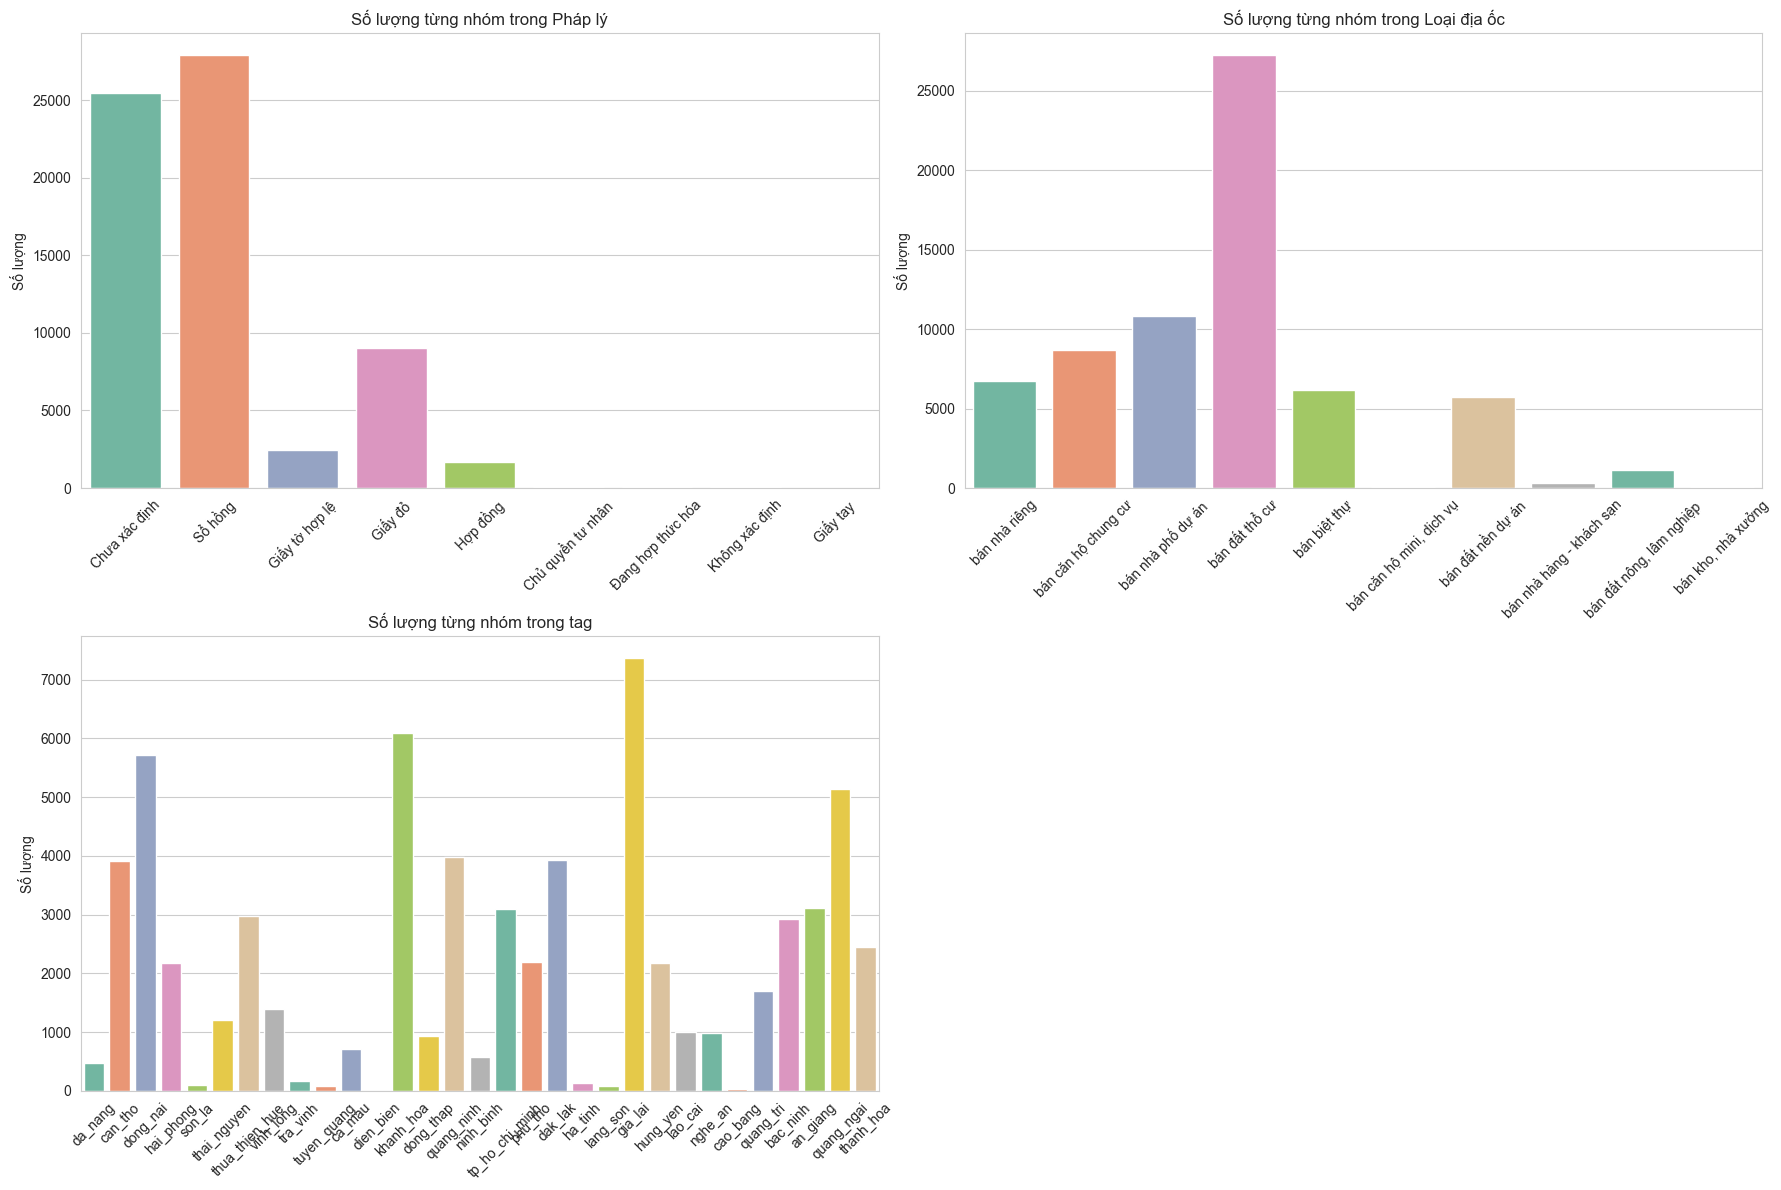

In [7]:
# 5.3. Trực quan hóa top 10 feature tương quan và phân loại categorical

# Lấy danh sách cột numeric & categorical
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_all = df.select_dtypes(include=["object"]).columns.tolist()


# Tính tương quan với Giá nhà
corr = df[num_cols_all].corr(numeric_only=True)["cleaned_price"].sort_values(ascending=False)

# Lấy top các numeric có tương quan mạnh nhất với Giá nhà (bỏ qua chính nó)
top_corr = corr.index[1:11]
print("Top các feature numeric tương quan mạnh nhất với Giá nhà:")
display(top_corr)

# Biểu đồ phân phối cho Top Numeric
if len(top_corr) > 0:
    n_rows = (len(top_corr) + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(top_corr):
        sns.histplot(df[col], kde=True, color="skyblue", ax=axes[i])
        axes[i].set_title(f"Phân phối của {col}")
    
    # Ẩn các axes thừa nếu số lượng lẻ
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()

# Phân tích biến categorical
# Hiển thị số lượng giá trị duy nhất của các biến categorical
cat_counts = df[cat_cols_all].nunique().sort_values()
top_cat = cat_counts.head(10).index.tolist()

print(f"Top {len(top_cat)} biến phân loại có ít giá trị duy nhất nhất:")
display(top_cat)

if len(top_cat) > 0:
    # Biểu đồ tròn cho các biến categorical
    n_rows = (len(top_cat) + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(18, 6 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(top_cat):
        value_counts = df[col].value_counts()
        labels = value_counts.index
        sizes = value_counts.values

        # Làm nổi từng phần
        explode = [0.05] * len(labels) if len(labels) > 0 else None

        wedges, texts, autotexts = axes[i].pie(
            sizes,
            labels=labels,
            autopct="%1.1f%%",
            startangle=90,
            colors=sns.color_palette("pastel", len(labels)),
            explode=explode,
            wedgeprops={"edgecolor": "white", "linewidth": 1.2},
            textprops={"fontsize": 10},
            labeldistance=1.15,
            pctdistance=0.8
        )

        axes[i].axis("equal")
        axes[i].set_title(f"Tỷ lệ phần trăm các nhóm trong {col}", fontsize=12, pad=15)
    
    # Ẩn các axes thừa
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


    # Biểu đồ cột cho các biến categorical
    fig, axes = plt.subplots(n_rows, 2, figsize=(18, 6 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(top_cat):
        sns.countplot(
            data=df,
            x=col,
            hue=col,
            palette="Set2",
            legend=False,
            ax=axes[i]
        )
        axes[i].tick_params(axis="x", rotation=45)
        axes[i].set_title(f"Số lượng từng nhóm trong {col}", fontsize=12)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Số lượng")
    
    # Ẩn các axes thừa
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# 1. Đặc trưng VỊ TRÍ KẾT HỢP (Interaction Feature)
# Kết hợp Loại nhà + Tỉnh thành (Ví dụ: "Nhà riêng_TPHCM" khác "Nhà riêng_LongAn")
df['Type_City'] = df['Loại địa ốc'] + "_" + df['tag']

# 2. Đặc trưng QUY MÔ SỬ DỤNG
# Tổng diện tích sàn = Diện tích đất * Số tầng (Nếu số tầng = 0 hoặc NaN thì coi như 1 tầng)
df['total_floor_area'] = df['cleaned_area'] * df['floor'].replace(0, 1)

# Tổng số phòng chức năng (Chỉ áp dụng cho Nhà, Đất sẽ tự động thấp do bed/bath=0)
df['total_rooms'] = df['bed'] + df['bath']

# 3. Đặc trưng TIỀM NĂNG MẶT TIỀN
# Diện tích lớn + Đường to = Giá trị thương mại cao (Cấp số nhân)
df['road_potential'] = df['cleaned_area'] * df['cleaned_road']

print("Đã tạo xong các features mới.")
display(df[['cleaned_area', 'floor', 'total_floor_area', 'road_potential']].head())

Đã tạo xong các features mới.


,cleaned_area,floor,total_floor_area,road_potential
0,77.0,3.0,231.0,962.5
1,205.0,2.0,410.0,2562.5
2,96.0,3.0,288.0,1200.0
3,92.0,3.0,276.0,1150.0
4,105.0,3.0,315.0,1312.5


In [ ]:
# 1. Xác định Biến Mục tiêu (Target) và Biến Đầu vào (Features)
# Logarit hóa giá nhà để phân phối chuẩn hơn (giúp model học tốt hơn)
y = np.log1p(df['cleaned_price'])

# Chọn các features sẽ đưa vào mô hình
num_cols = [
    'cleaned_area', 'cleaned_road', 'bed', 'bath', 'floor', 
    'is_land', 'total_floor_area', 'road_potential', 'total_rooms'
]
cat_cols = ['tag', 'Pháp lý', 'Loại địa ốc', 'Type_City'] 

# 2. Xử lý dữ liệu dạng chữ (Categorical) -> One-Hot Encoding
X = df[num_cols + cat_cols] 
y = np.log1p(df['cleaned_price'])

# - Biến số: Chỉ cần chuẩn hóa (StandardScaler)
# - Biến chữ: Dùng OneHotEncoder của Sklearn
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    verbose_feature_names_out=False
)

print(f"Dữ liệu huấn luyện: {X.shape[0]} dòng, {X.shape[1]} cột")

Dữ liệu huấn luyện: 66823 dòng, 13 cột


In [ ]:
# 8. Split train/test/validation

# 1. Tách ra một tập Test riêng (Hold-out) để đánh giá cuối cùng (10% dữ liệu)
# Tách từ dữ liệu gốc để có tập kiểm tra độc lập
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)

# 2. Tách tập còn lại thành Train và Validation (80% - 20% của phần còn lại)
# Dùng để huấn luyện và tinh chỉnh mô hình (Hyperparameter tuning)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, random_state=RANDOM_STATE)

print(f"Train set: {X_train.shape}")
print(f"Valid set: {X_valid.shape}")
print(f"Test set (Hold-out): {X_test.shape}")

Train set: (48112, 13)
Valid set: (12028, 13)
Test set (Hold-out): (6683, 13)


In [11]:
# 9. Ridge
ridge_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", Ridge(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {"model__alpha": [0.0005, 0.001, 0.005, 0.01, 0.05]}
gs_ridge = GridSearchCV(ridge_pipe, grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=N_JOBS)

gs_ridge.fit(X_train, y_train)
pred_ridge_log = gs_ridge.predict(X_valid)
ev_ridge = eval_on_logscale(pred_ridge_log, y_valid)
ev_ridge

{'rmse_log': 0.6697941255274418,
 'rmse': 3717.1119417893187,
 'r2_log': 0.4904617506715421}

In [12]:
# 10. Random Forest
rf_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=700,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        max_features=0.8,
        min_samples_leaf=1,
        min_samples_split=2,
        bootstrap=True
    ))
])

rf_pipe.fit(X_train, y_train)
pred_rf_log = rf_pipe.predict(X_valid)
ev_rf = eval_on_logscale(pred_rf_log, y_valid)
ev_rf

{'rmse_log': 0.5933381359558867,
 'rmse': 3078.5608490168383,
 'r2_log': 0.6001485751446595}

In [13]:
# 11. XGBoost 
prep_fit = preprocessor.fit(X_train)
Xtr = prep_fit.transform(X_train)
Xva = prep_fit.transform(X_valid)

xgb_base = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)

xgb_base.fit(
    Xtr, y_train,
    eval_set=[(Xva, y_valid)],
    verbose=50
)

pred_xgb_log = xgb_base.predict(Xva)
ev_xgb = eval_on_logscale(pred_xgb_log, y_valid)
ev_xgb

[0]	validation_0-rmse:0.92010
[50]	validation_0-rmse:0.67895
[50]	validation_0-rmse:0.67895
[100]	validation_0-rmse:0.65512
[100]	validation_0-rmse:0.65512
[150]	validation_0-rmse:0.64405
[150]	validation_0-rmse:0.64405
[200]	validation_0-rmse:0.63718
[200]	validation_0-rmse:0.63718
[250]	validation_0-rmse:0.63183
[250]	validation_0-rmse:0.63183
[300]	validation_0-rmse:0.62714
[300]	validation_0-rmse:0.62714
[350]	validation_0-rmse:0.62355
[350]	validation_0-rmse:0.62355
[400]	validation_0-rmse:0.62043
[400]	validation_0-rmse:0.62043
[450]	validation_0-rmse:0.61794
[450]	validation_0-rmse:0.61794
[500]	validation_0-rmse:0.61571
[500]	validation_0-rmse:0.61571
[550]	validation_0-rmse:0.61352
[550]	validation_0-rmse:0.61352
[600]	validation_0-rmse:0.61148
[600]	validation_0-rmse:0.61148
[650]	validation_0-rmse:0.61007
[650]	validation_0-rmse:0.61007
[700]	validation_0-rmse:0.60876
[700]	validation_0-rmse:0.60876
[750]	validation_0-rmse:0.60751
[750]	validation_0-rmse:0.60751
[800]	valida

{'rmse_log': 0.5921061463232563,
 'rmse': 3078.807877193387,
 'r2_log': 0.6018073304375027}

In [14]:
# # Lưu model
# import joblib

# xgb_pipe = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("model", xgb_base)
# ])

# joblib.dump(xgb_pipe, "house_price_xgb.joblib")
# print("Đã lưu model vào house_price_xgb.joblib")

In [15]:
# 12. So sánh kết quả
res = pd.DataFrame([
    {"Model":"Ridge",        **ev_ridge},
    {"Model":"RandomForest", **ev_rf},
    {"Model":"XGBoost",      **ev_xgb},
]).sort_values("rmse")
display(res.reset_index(drop=True))


,Model,rmse_log,rmse,r2_log
0,RandomForest,0.593338,3078.560849,0.600149
1,XGBoost,0.592106,3078.807877,0.601807
2,Ridge,0.669794,3717.111942,0.490462


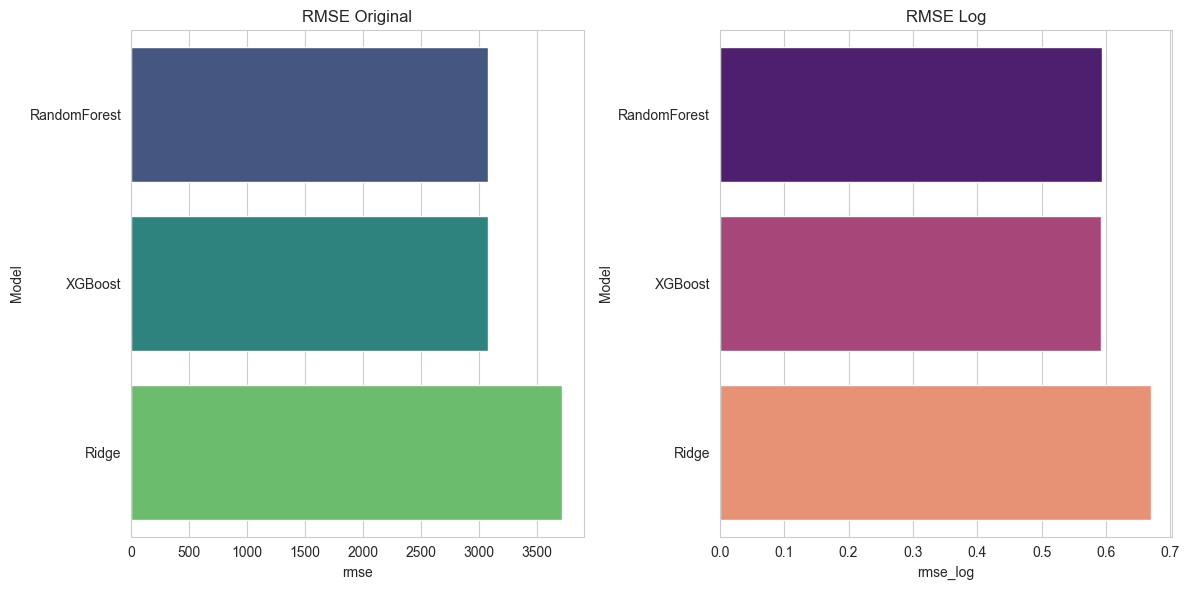

In [16]:
# 13. Biểu đồ so sánh RMSE các mô hình

res_plot = res.sort_values("rmse", ascending=True).reset_index(drop=True)

fig, axes = plt.subplots(1, 2, figsize=(12,6))

sns.barplot(data=res_plot, x="rmse", y="Model", hue="Model",
            ax=axes[0], palette="viridis", legend=False)
axes[0].set_title("RMSE Original")

sns.barplot(data=res_plot, x="rmse_log", y="Model", hue="Model",
            ax=axes[1], palette="magma", legend=False)
axes[1].set_title("RMSE Log")

plt.tight_layout()
plt.show()


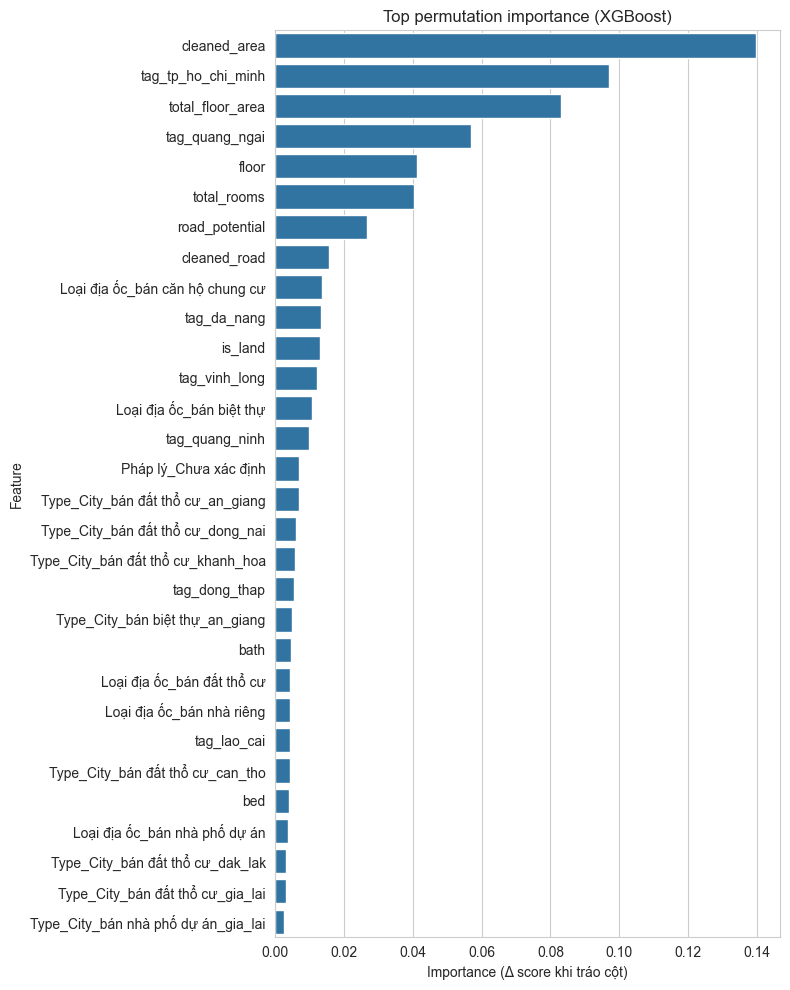

In [ ]:
# 14. Permutation Importance (XGBoost)

# Dùng preprocessor đã fit cho XGBoost
Xva_trans = prep_fit.transform(X_valid)

# chuyển dense nếu là sparse
if hasattr(Xva_trans, "toarray"):
    Xva_use = Xva_trans.toarray()
else:
    Xva_use = Xva_trans

# Model XGBoost đã fit
xgb_fitted = xgb_base

# Permutation importance
r = permutation_importance(
    xgb_fitted, Xva_use, y_valid,
    n_repeats=5, random_state=RANDOM_STATE, n_jobs=N_JOBS
)

# Tên feature theo đúng thứ tự cột sau ColumnTransformer (num trước, rồi cat)
# Xử lý trường hợp 'cat' là Pipeline hoặc OneHotEncoder trực tiếp
cat_transformer = prep_fit.named_transformers_["cat"]
if hasattr(cat_transformer, "named_steps"):
    cat_names = cat_transformer.named_steps["onehot"].get_feature_names_out(cat_cols)
else:
    cat_names = cat_transformer.get_feature_names_out(cat_cols)

feat_names = list(num_cols) + list(cat_names)

# Top feature quan trọng nhất
imp = pd.Series(r.importances_mean, index=feat_names).sort_values(ascending=False).head(30)

plt.figure(figsize=(8,10))
sns.barplot(x=imp.values, y=imp.index)
plt.title("Top permutation importance (XGBoost)")
plt.xlabel("Importance (Δ score khi tráo cột)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Đang huấn luyện lại model trên toàn bộ tập Train + Valid...

Kết quả đánh giá trên tập Test (Hold-out):

Kết quả đánh giá trên tập Test (Hold-out):


{'rmse_log': 0.6023689899590737,
 'rmse': 3088.02926475247,
 'r2_log': 0.6003613331000921}


Một số ví dụ dự đoán:


,Giá thực tế,Giá dự đoán,Sai lệch,Sai lệch %
45634,1600.0,1693.804688,-93.804688,-5.862793
65783,13000.0,7540.539551,5459.460449,41.995850
46055,1450.0,1613.795898,-163.795898,-11.296269
45459,1800.0,1332.966797,467.033203,25.946289
33466,3630.0,4135.740234,-505.740234,-13.932238
31273,32000.0,18986.837891,13013.162109,40.666132
19129,3900.0,2137.253418,1762.746582,45.198630
30125,3000.0,3176.543701,-176.543701,-5.884790
55704,1265.0,1501.527100,-236.527100,-18.697794
65205,1800.0,1760.304810,39.695190,2.205288


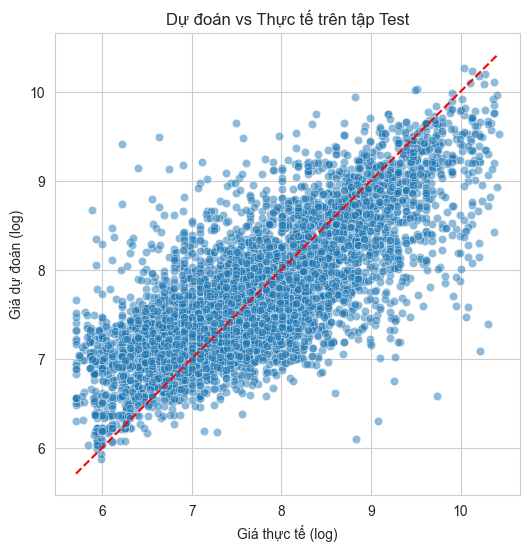

In [ ]:
# 15. Đánh giá trên tập Test (Hold-out)

# 1. Gộp Train + Valid để huấn luyện lại mô hình tốt nhất trên nhiều dữ liệu hơn
X_final_train = pd.concat([X_train, X_valid], axis=0)
y_final_train = pd.concat([y_train, y_valid], axis=0)

# 2. Fit Preprocessor trên toàn bộ tập huấn luyện (Train + Valid)
preprocessor_final = preprocessor.fit(X_final_train)
X_final_train_p = preprocessor_final.transform(X_final_train)
X_test_p = preprocessor_final.transform(X_test)

# 3. Chọn model tốt nhất để đánh giá (Ví dụ: XGBoost)
final_model = xgb_base 

print("Đang huấn luyện lại model trên toàn bộ tập Train + Valid...")
final_model.fit(X_final_train_p, y_final_train)

# 4. Dự đoán trên tập Test
pred_test_log = final_model.predict(X_test_p)

# 5. Đánh giá kết quả
ev_test = eval_on_logscale(pred_test_log, y_test)
print("\nKết quả đánh giá trên tập Test (Hold-out):")
display(ev_test)

# 6. So sánh giá thực tế và dự đoán (Top 10 mẫu)
test_results = pd.DataFrame({
    "Giá thực tế": np.expm1(y_test),
    "Giá dự đoán": np.expm1(pred_test_log)
})
test_results["Sai lệch"] = test_results["Giá thực tế"] - test_results["Giá dự đoán"]
test_results["Sai lệch %"] = (test_results["Sai lệch"] / test_results["Giá thực tế"]) * 100

print("\nMột số ví dụ dự đoán:")
display(test_results.head(10))

# Vẽ biểu đồ phân tán dự đoán vs thực tế
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=pred_test_log, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Giá thực tế (log)")
plt.ylabel("Giá dự đoán (log)")
plt.title("Dự đoán vs Thực tế trên tập Test")
plt.show()